In [1]:
# Cell 1: Install Required Packages
!pip install scikit-learn xgboost joblib plotly imbalanced-learn -q

print("✅ Machine learning packages installed successfully!")

✅ Machine learning packages installed successfully!



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_auc_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ All machine learning libraries imported successfully!")

✅ All machine learning libraries imported successfully!


In [3]:
# Cell 3: Configuration
# Model Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

print("🔧 MODEL TRAINING CONFIGURATION")
print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE}")
print(f"CV Folds: {CV_FOLDS}")

🔧 MODEL TRAINING CONFIGURATION
Random State: 42
Test Size: 0.2
CV Folds: 5


In [4]:
# Cell 4: Load and Prepare Data
print("📥 LOADING DATASET...")

try:
    # Load the comprehensive dataset from Module 1
    df = pd.read_csv('../data/pollution_data_comprehensive.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    print(f"✅ Dataset loaded successfully: {df.shape[0]:,} rows, {df.shape[1]} columns")
    print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"📍 Sensors: {df['sensor_name'].nunique()}")
    
except FileNotFoundError:
    print("❌ Dataset not found! Please run Module 1 first.")
    raise

# Display basic info
print("\n📊 DATASET OVERVIEW:")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
display(df.head(3))

📥 LOADING DATASET...
✅ Dataset loaded successfully: 5,768 rows, 31 columns
📅 Date range: 2025-09-30 10:08:36.680470 to 2025-10-30 10:08:36.680470
📍 Sensors: 8

📊 DATASET OVERVIEW:
Columns: ['timestamp', 'sensor_id', 'sensor_name', 'sensor_latitude', 'sensor_longitude', 'area_type', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'aqi', 'temperature_c', 'humidity_percent', 'pressure_hpa', 'wind_speed_ms', 'wind_direction_deg', 'weather_condition', 'road_edges', 'road_length_km', 'industrial_area', 'commercial_area', 'residential_area', 'green_space', 'building_density', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour']

First 3 rows:


,timestamp,sensor_id,sensor_name,sensor_latitude,sensor_longitude,area_type,PM2.5,PM10,NO2,SO2,...,industrial_area,commercial_area,residential_area,green_space,building_density,hour,day_of_week,month,is_weekend,is_rush_hour
0,2025-09-30 10:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,37.85,54.45,25.34,15.30,...,5,25,36,68,10774,10,1,9,0,0
1,2025-09-30 11:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,31.44,72.31,17.07,11.19,...,5,25,36,68,10774,11,1,9,0,0
2,2025-09-30 12:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,29.30,66.53,19.39,6.24,...,5,25,36,68,10774,12,1,9,0,0


In [5]:
# Cell 5: Create Intelligent Pollution Source Target
print("🎯 CREATING POLLUTION SOURCE TARGET VARIABLE...")

def create_intelligent_pollution_source(df):
    """Create realistic pollution source labels based on multiple factors"""
    
    # Calculate average pollution levels by sensor
    sensor_stats = df.groupby('sensor_name').agg({
        'PM2.5': ['mean', 'std'],
        'PM10': 'mean',
        'NO2': 'mean', 
        'SO2': 'mean',
        'CO': 'mean',
        'industrial_area': 'first',
        'commercial_area': 'first',
        'residential_area': 'first'
    }).round(2)
    
    sensor_stats.columns = ['_'.join(col).strip() for col in sensor_stats.columns.values]
    sensor_stats = sensor_stats.reset_index()
    
    def determine_pollution_source(row):
        pm25 = row['PM2.5_mean']
        pm10 = row['PM10_mean']
        no2 = row['NO2_mean']
        so2 = row['SO2_mean']
        co = row['CO_mean']
        industrial_area = row['industrial_area_first']
        commercial_area = row['commercial_area_first']
        
        # Multi-factor source determination
        industrial_score = 0
        traffic_score = 0
        commercial_score = 0
        residential_score = 0
        
        # Industrial characteristics
        if so2 > 20 or (pm25 > 60 and pm10 > 100):
            industrial_score += 2
        if industrial_area > 5:
            industrial_score += 1
            
        # Traffic characteristics  
        if no2 > 40 or co > 1.5:
            traffic_score += 2
        if pm25 > 45 and pm25 <= 65:
            traffic_score += 1
            
        # Commercial characteristics
        if 35 <= pm25 <= 55 and commercial_area > 10:
            commercial_score += 2
            
        # Residential characteristics
        if pm25 < 35 and no2 < 25:
            residential_score += 2
            
        # Determine final source
        scores = {
            'Industrial': industrial_score,
            'Traffic': traffic_score, 
            'Commercial': commercial_score,
            'Residential': residential_score
        }
        
        max_source = max(scores, key=scores.get)
        return max_source if scores[max_source] > 0 else 'Background'
    
    # Apply source determination
    sensor_stats['pollution_source'] = sensor_stats.apply(determine_pollution_source, axis=1)
    
    # Merge back to original dataframe
    df_with_target = df.merge(sensor_stats[['sensor_name', 'pollution_source']], 
                             on='sensor_name', how='left')
    
    return df_with_target

# Create target variable
df = create_intelligent_pollution_source(df)

print("✅ Pollution source target created!")
print("\n📊 SOURCE DISTRIBUTION:")
source_distribution = df['pollution_source'].value_counts()
for source, count in source_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"  • {source}: {count:,} records ({percentage:.1f}%)")

🎯 CREATING POLLUTION SOURCE TARGET VARIABLE...
✅ Pollution source target created!

📊 SOURCE DISTRIBUTION:
  • Residential: 2,884 records (50.0%)
  • Traffic: 1,442 records (25.0%)
  • Commercial: 1,442 records (25.0%)


In [6]:
    # Cell 6: Feature Engineering
print("⚙️ PERFORMING FEATURE ENGINEERING...")

# Create additional temporal features
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# Create pollution ratios and indices
df['pm_ratio'] = df['PM2.5'] / df['PM10']
df['pollution_index'] = (df['PM2.5'] / 35 + df['PM10'] / 50 + df['NO2'] / 40) / 3

# Weather-based features
df['temp_humidity_interaction'] = df['temperature_c'] * df['humidity_percent'] / 100
df['wind_effect'] = df['wind_speed_ms'] * df['pollution_index']

print("✅ Feature engineering completed!")
print(f"New features created: hour_sin, hour_cos, day_sin, day_cos, pm_ratio, pollution_index, temp_humidity_interaction, wind_effect")

⚙️ PERFORMING FEATURE ENGINEERING...
✅ Feature engineering completed!
New features created: hour_sin, hour_cos, day_sin, day_cos, pm_ratio, pollution_index, temp_humidity_interaction, wind_effect


In [7]:
# Cell 7: Prepare Features and Target
print("🔧 PREPARING FEATURES FOR MODEL TRAINING...")

# Define feature sets
pollution_features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'aqi', 'pm_ratio', 'pollution_index']
weather_features = ['temperature_c', 'humidity_percent', 'pressure_hpa', 'wind_speed_ms', 'temp_humidity_interaction', 'wind_effect']
temporal_features = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
location_features = ['road_edges', 'road_length_km', 'industrial_area', 'commercial_area', 'residential_area', 'green_space', 'building_density']

# Combine all possible features
all_possible_features = pollution_features + weather_features + temporal_features + location_features

# Select only features that exist in the dataframe
available_features = [col for col in all_possible_features if col in df.columns]

print(f"📋 USING {len(available_features)} FEATURES:")
for i, feature in enumerate(available_features, 1):
    print(f"  {i:2d}. {feature}")

# Prepare X and y
X = df[available_features]
y = df['pollution_source']

print(f"\n📊 FINAL DATA SHAPE:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")
print(f"  Target classes: {list(y.unique())}")

🔧 PREPARING FEATURES FOR MODEL TRAINING...
📋 USING 31 FEATURES:
   1. PM2.5
   2. PM10
   3. NO2
   4. SO2
   5. CO
   6. O3
   7. aqi
   8. pm_ratio
   9. pollution_index
  10. temperature_c
  11. humidity_percent
  12. pressure_hpa
  13. wind_speed_ms
  14. temp_humidity_interaction
  15. wind_effect
  16. hour
  17. day_of_week
  18. month
  19. is_weekend
  20. is_rush_hour
  21. hour_sin
  22. hour_cos
  23. day_sin
  24. day_cos
  25. road_edges
  26. road_length_km
  27. industrial_area
  28. commercial_area
  29. residential_area
  30. green_space
  31. building_density

📊 FINAL DATA SHAPE:
  X (features): (5768, 31)
  y (target): (5768,)
  Target classes: ['Residential', 'Traffic', 'Commercial']


In [8]:
# Cell 8: Handle Missing Values and Scale Features
print("🔧 PREPROCESSING DATA...")

# Check for missing values
missing_before = X.isnull().sum().sum()
print(f"Missing values before imputation: {missing_before}")

if missing_before > 0:
    # Use median imputation for missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
    print(f"✅ Missing values handled: {missing_before} → 0")
else:
    imputer = None
    X_imputed = X.copy()
    print("✅ No missing values found")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("✅ Features scaled using StandardScaler")

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"✅ Target variable encoded")
print(f"   Class mapping: {list(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

🔧 PREPROCESSING DATA...
Missing values before imputation: 0
✅ No missing values found
✅ Features scaled using StandardScaler
✅ Target variable encoded
   Class mapping: [('Commercial', np.int64(0)), ('Residential', np.int64(1)), ('Traffic', np.int64(2))]


In [9]:
# Cell 9: Train-Test Split
print("📊 SPLITTING DATA...")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y_encoded
)

print(f"✅ Data split completed:")
print(f"   Training set: {X_train.shape[0]:,} samples")
print(f"   Testing set: {X_test.shape[0]:,} samples")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: {len(np.unique(y_train))}")

# Check class distribution in splits
print(f"\n📈 CLASS DISTRIBUTION:")
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

for i, class_name in enumerate(label_encoder.classes_):
    train_pct = (train_counts[i] / len(y_train)) * 100
    test_pct = (test_counts[i] / len(y_test)) * 100
    print(f"   {class_name:<12}: Train {train_counts[i]:>5,} ({train_pct:5.1f}%) | Test {test_counts[i]:>5,} ({test_pct:5.1f}%)")

📊 SPLITTING DATA...
✅ Data split completed:
   Training set: 4,614 samples
   Testing set: 1,154 samples
   Features: 31
   Classes: 3

📈 CLASS DISTRIBUTION:
   Commercial  : Train 1,153 ( 25.0%) | Test   289 ( 25.0%)
   Residential : Train 2,307 ( 50.0%) | Test   577 ( 50.0%)
   Traffic     : Train 1,154 ( 25.0%) | Test   288 ( 25.0%)


In [10]:
# Cell 10: Initialize Models
print("🤖 INITIALIZING MACHINE LEARNING MODELS...")

models = {
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE, 
        n_jobs=-1,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    )
}

print("✅ Models initialized:")
for name, model in models.items():
    print(f"   • {name}")

🤖 INITIALIZING MACHINE LEARNING MODELS...
✅ Models initialized:
   • Random Forest
   • XGBoost
   • Decision Tree


In [11]:
# Cell 11: Hyperparameter Tuning
print("🎯 TUNING HYPERPARAMETERS...")

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [6, 9],
        'learning_rate': [0.1, 0.2],
        'subsample': [0.8, 1.0]
    },
    'Decision Tree': {
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

tuned_models = {}
best_params = {}
cv_results = {}

for name, model in models.items():
    print(f"\n   Tuning {name}...")
    
    try:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=min(CV_FOLDS, 3),  # Use smaller CV for speed
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        tuned_models[name] = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_
        cv_results[name] = grid_search.best_score_
        
        print(f"     ✅ Best parameters: {grid_search.best_params_}")
        print(f"     ✅ Best CV score: {grid_search.best_score_:.4f}")
        
    except Exception as e:
        print(f"     ⚠️  Tuning failed: {e}")
        print(f"     Using default parameters...")
        tuned_models[name] = model
        tuned_models[name].fit(X_train, y_train)
        best_params[name] = "Default parameters"
        cv_results[name] = "N/A"

print("\n✅ Hyperparameter tuning completed!")

🎯 TUNING HYPERPARAMETERS...

   Tuning Random Forest...
     ✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
     ✅ Best CV score: 1.0000

   Tuning XGBoost...
     ✅ Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
     ✅ Best CV score: 1.0000

   Tuning Decision Tree...
     ✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
     ✅ Best CV score: 1.0000

✅ Hyperparameter tuning completed!


In [12]:
# Cell 12: Model Training and Evaluation
print("📈 TRAINING AND EVALUATING MODELS...")

results = {}
predictions = {}
feature_importances = {}

for name, model in tuned_models.items():
    print(f"\n   Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Cross-validation scores
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=min(CV_FOLDS, 3), scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except:
        cv_mean = accuracy
        cv_std = 0
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }
    
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Store feature importances if available
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_
    
    print(f"     ✅ Training completed")
    print(f"     📊 Test Accuracy: {accuracy:.4f}")
    print(f"     📊 CV Accuracy: {cv_mean:.4f} (±{cv_std:.4f})")
    print(f"     📊 F1-Score: {f1:.4f}")

print("\n✅ All models trained and evaluated!")

📈 TRAINING AND EVALUATING MODELS...

   Training Random Forest...
     ✅ Training completed
     📊 Test Accuracy: 1.0000
     📊 CV Accuracy: 1.0000 (±0.0000)
     📊 F1-Score: 1.0000

   Training XGBoost...
     ✅ Training completed
     📊 Test Accuracy: 1.0000
     📊 CV Accuracy: 1.0000 (±0.0000)
     📊 F1-Score: 1.0000

   Training Decision Tree...
     ✅ Training completed
     📊 Test Accuracy: 1.0000
     📊 CV Accuracy: 1.0000 (±0.0000)
     📊 F1-Score: 1.0000

✅ All models trained and evaluated!


In [13]:
# Cell 13: Model Performance Comparison
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 70)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean']]

# Display results table
print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'CV Score':<10}")
print("-" * 70)
for model, metrics in results.items():
    print(f"{model:<15} {metrics['accuracy']:.4f}    {metrics['precision']:.4f}    {metrics['recall']:.4f}    {metrics['f1_score']:.4f}    {metrics['cv_mean']:.4f}")

# Find best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name} (Accuracy: {best_accuracy:.4f})")

📊 MODEL PERFORMANCE COMPARISON
Model           Accuracy   Precision  Recall     F1-Score   CV Score  
----------------------------------------------------------------------
Random Forest   1.0000    1.0000    1.0000    1.0000    1.0000
XGBoost         1.0000    1.0000    1.0000    1.0000    1.0000
Decision Tree   1.0000    1.0000    1.0000    1.0000    1.0000

🏆 BEST MODEL: Random Forest (Accuracy: 1.0000)


📈 CREATING PERFORMANCE VISUALIZATIONS...


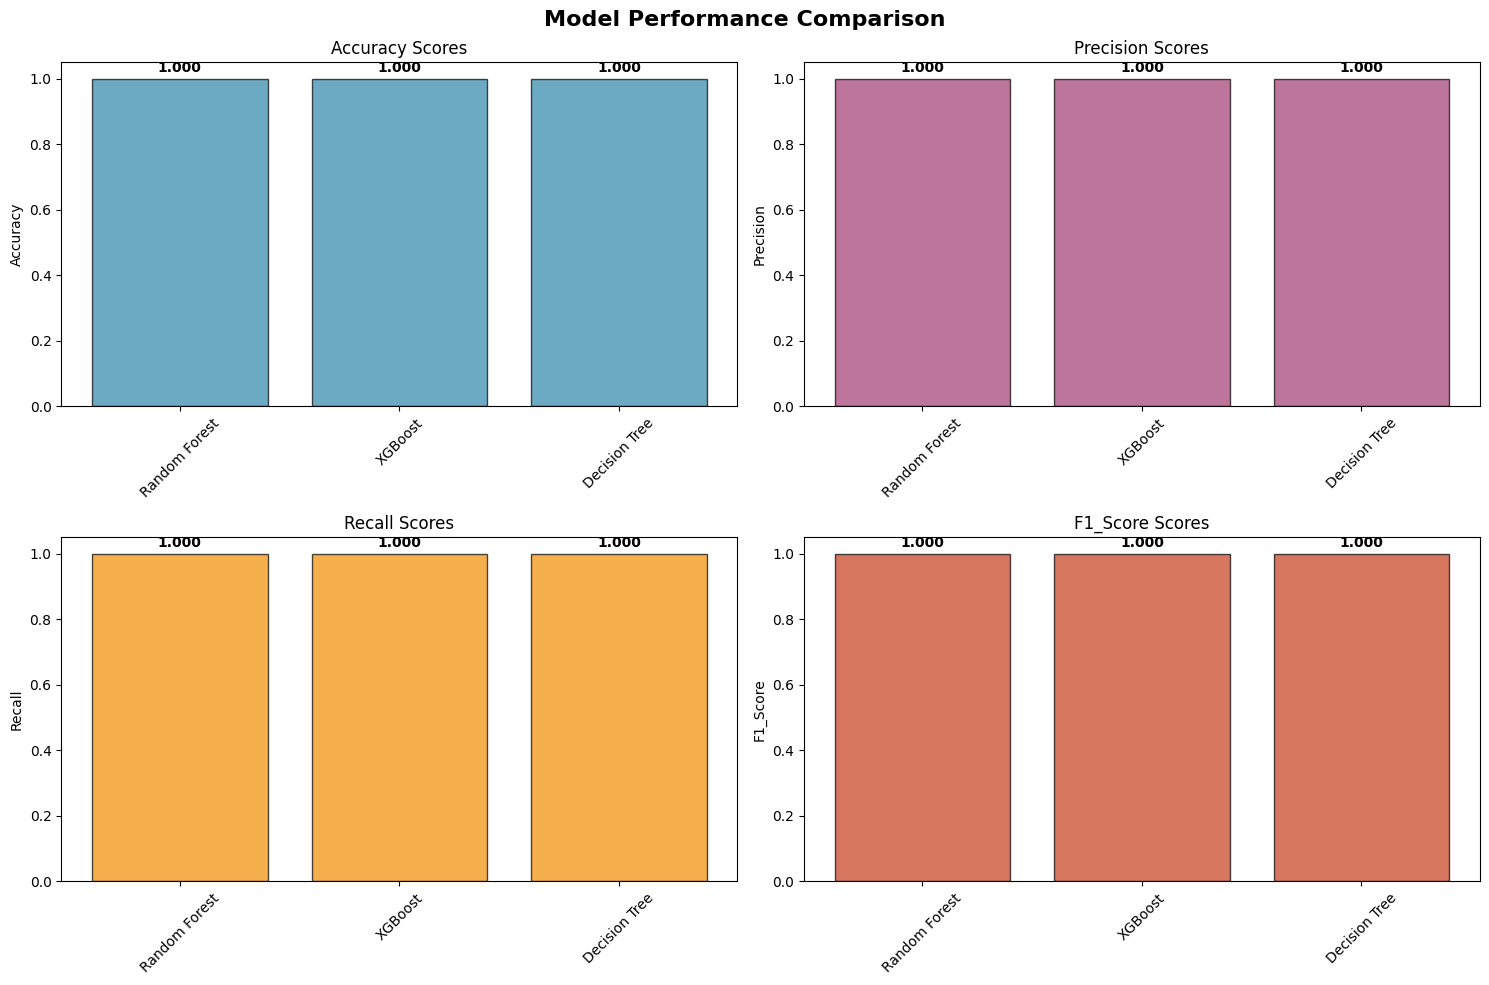

In [14]:
# Cell 14: Visualize Model Performance
print("📈 CREATING PERFORMANCE VISUALIZATIONS...")

# Create performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

for i, metric in enumerate(metrics_to_plot):
    row, col = i // 2, i % 2
    values = [results[model][metric] for model in results_df.index]
    
    bars = axes[row, col].bar(results_df.index, values, color=colors[i], alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{metric.title()} Scores')
    axes[row, col].set_ylabel(metric.title())
    axes[row, col].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

🎯 CONFUSION MATRICES


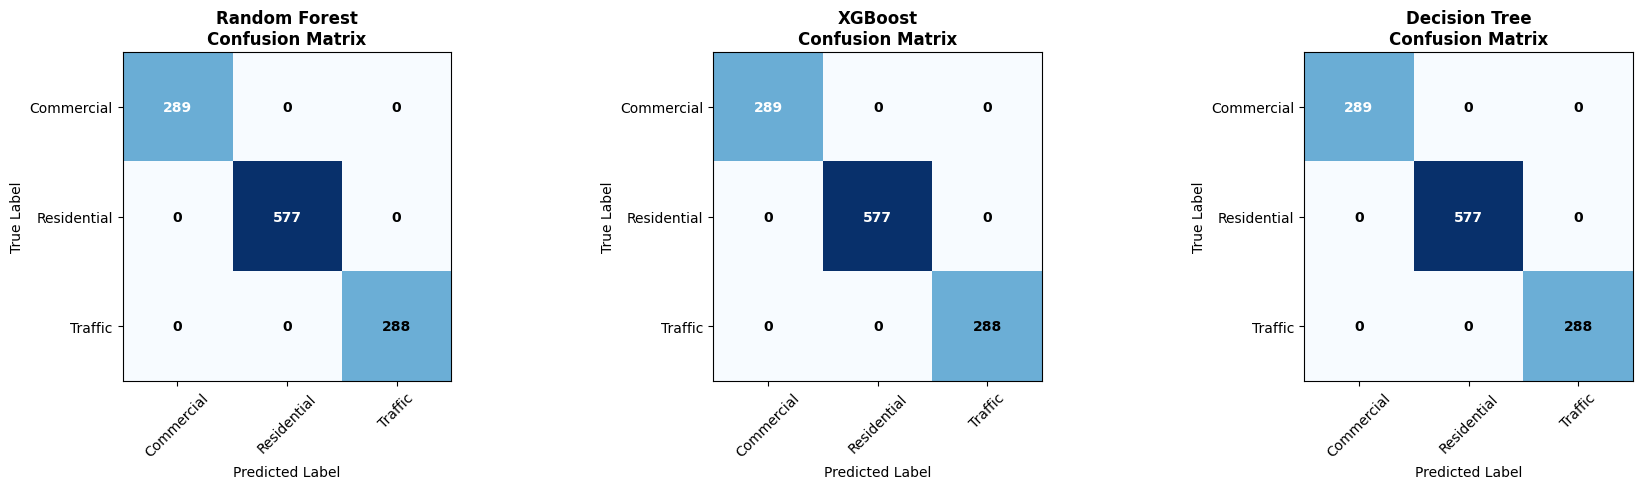

In [15]:
# Cell 15: Confusion Matrices
print("🎯 CONFUSION MATRICES")

# Create confusion matrices for all models
n_models = len(tuned_models)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

class_names = label_encoder.classes_

for idx, (name, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, preds['y_pred'])
    
    # Plot confusion matrix
    im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center",
                          color="white" if cm[i, j] > thresh else "black",
                          fontweight='bold')
    
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xticks(range(len(class_names)))
    axes[idx].set_yticks(range(len(class_names)))
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_yticklabels(class_names)

plt.tight_layout()
plt.show()

🔍 ANALYZING FEATURE IMPORTANCE...


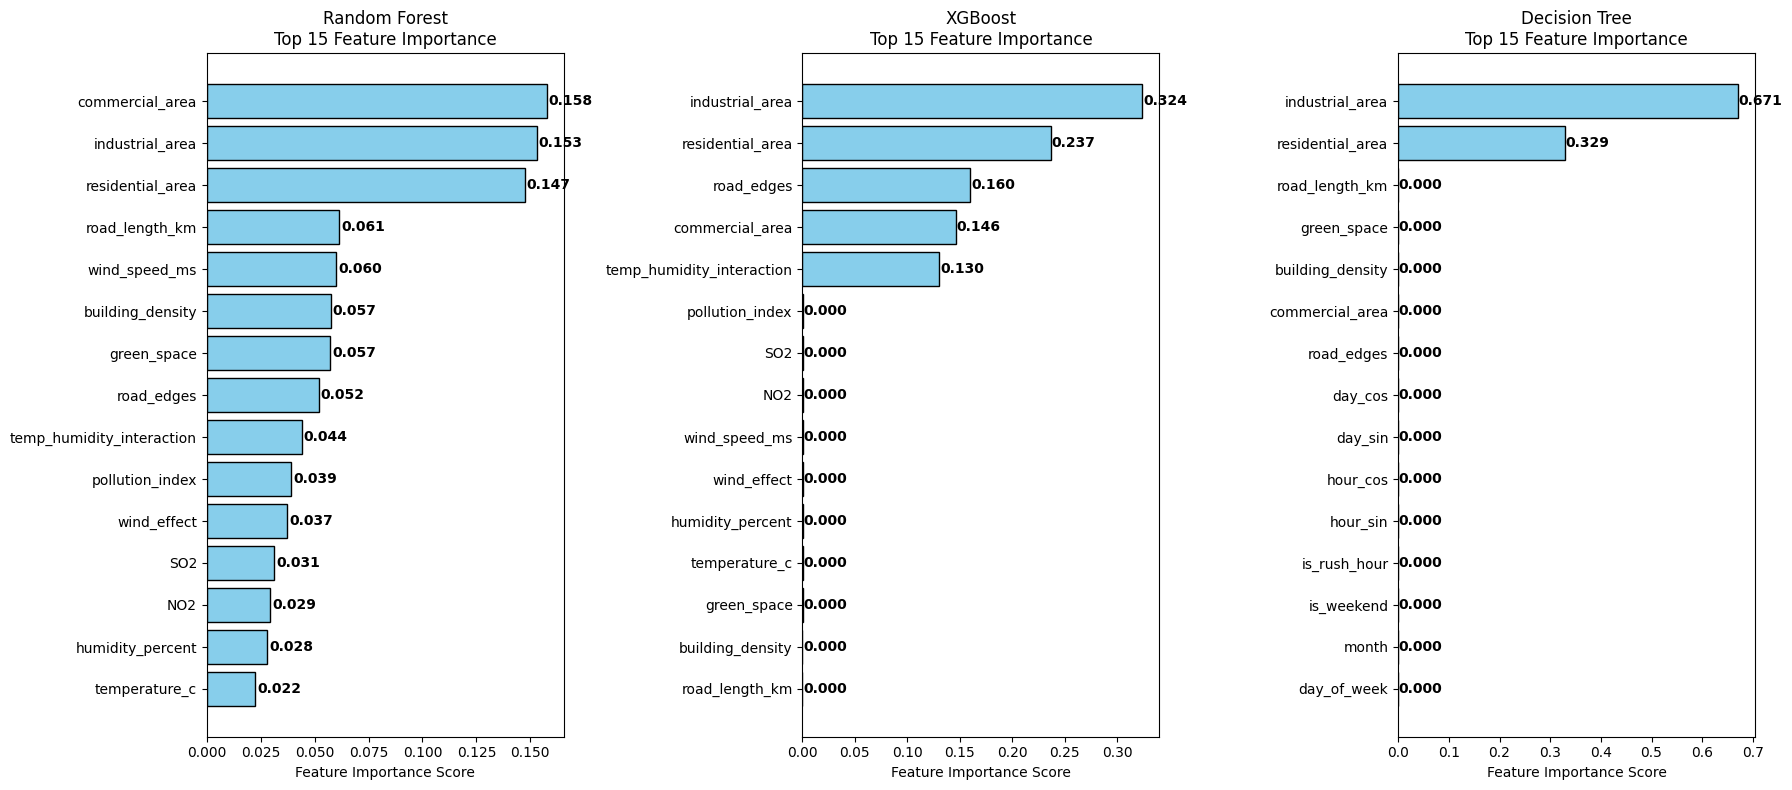


🏆 TOP 5 MOST IMPORTANT FEATURES:

Random Forest:
  1. commercial_area (importance: 0.1576)
  2. industrial_area (importance: 0.1529)
  3. residential_area (importance: 0.1474)
  4. road_length_km (importance: 0.0613)
  5. wind_speed_ms (importance: 0.0601)

XGBoost:
  1. industrial_area (importance: 0.3242)
  2. residential_area (importance: 0.2368)
  3. road_edges (importance: 0.1603)
  4. commercial_area (importance: 0.1462)
  5. temp_humidity_interaction (importance: 0.1304)

Decision Tree:
  1. industrial_area (importance: 0.6707)
  2. residential_area (importance: 0.3293)
  3. road_length_km (importance: 0.0000)
  4. green_space (importance: 0.0000)
  5. building_density (importance: 0.0000)


In [16]:
# Cell 16: Feature Importance Analysis
print("🔍 ANALYZING FEATURE IMPORTANCE...")

# Plot feature importance for models that support it
models_with_importance = [name for name in tuned_models.keys() 
                         if hasattr(tuned_models[name], 'feature_importances_')]

if models_with_importance:
    n_models = len(models_with_importance)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, name in enumerate(models_with_importance):
        importance = feature_importances[name]
        
        # Get top 15 features
        top_indices = np.argsort(importance)[::-1][:15]
        top_features = [available_features[i] for i in top_indices]
        top_importance = importance[top_indices]
        
        # Create horizontal bar plot
        y_pos = np.arange(len(top_features))
        axes[idx].barh(y_pos, top_importance, align='center', color='skyblue', edgecolor='black')
        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(top_features)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('Feature Importance Score')
        axes[idx].set_title(f'{name}\nTop 15 Feature Importance')
        
        # Add value labels
        for i, v in enumerate(top_importance):
            axes[idx].text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Display top 5 features for each model
    print("\n🏆 TOP 5 MOST IMPORTANT FEATURES:")
    for name in models_with_importance:
        importance = feature_importances[name]
        top_indices = np.argsort(importance)[::-1][:5]
        top_features = [available_features[i] for i in top_indices]
        print(f"\n{name}:")
        for i, feature in enumerate(top_features, 1):
            print(f"  {i}. {feature} (importance: {importance[top_indices[i-1]]:.4f})")
else:
    print("No feature importance data available for the trained models.")

In [17]:
# Cell 17: Detailed Classification Reports
print("📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 70)

for name, preds in predictions.items():
    print(f"\n{name}:")
    print("-" * 50)
    print(classification_report(y_test, preds['y_pred'], 
                              target_names=label_encoder.classes_,
                              digits=4))

📋 DETAILED CLASSIFICATION REPORTS

Random Forest:
--------------------------------------------------
              precision    recall  f1-score   support

  Commercial     1.0000    1.0000    1.0000       289
 Residential     1.0000    1.0000    1.0000       577
     Traffic     1.0000    1.0000    1.0000       288

    accuracy                         1.0000      1154
   macro avg     1.0000    1.0000    1.0000      1154
weighted avg     1.0000    1.0000    1.0000      1154


XGBoost:
--------------------------------------------------
              precision    recall  f1-score   support

  Commercial     1.0000    1.0000    1.0000       289
 Residential     1.0000    1.0000    1.0000       577
     Traffic     1.0000    1.0000    1.0000       288

    accuracy                         1.0000      1154
   macro avg     1.0000    1.0000    1.0000      1154
weighted avg     1.0000    1.0000    1.0000      1154


Decision Tree:
--------------------------------------------------
         

In [19]:
# Cell 18: Save Models and Artifacts
print("💾 SAVING MODELS AND ARTIFACTS...")

# ✅ Import required modules
import os
import joblib
from datetime import datetime

# ✅ Ensure the folder exists
os.makedirs('../models', exist_ok=True)

# ✅ Check if required variables exist before saving
required_vars = ['tuned_models', 'imputer', 'scaler', 'label_encoder',
                 'available_features', 'best_params', 'results',
                 'best_accuracy', 'best_model_name', 'df']

for var in required_vars:
    if var not in globals():
        raise NameError(f"❌ Missing variable: '{var}'. Please make sure it’s defined before running this cell.")

# ✅ Save model artifacts
model_artifacts = {
    'models': tuned_models,
    'preprocessing': {
        'imputer': imputer,
        'scaler': scaler,
        'label_encoder': label_encoder
    },
    'feature_names': available_features,
    'best_params': best_params,
    'results': results,
    'metadata': {
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_shape': df.shape,
        'test_accuracy': best_accuracy,
        'best_model': best_model_name
    }
}

# ✅ Save complete artifacts
joblib.dump(model_artifacts, '../models/pollution_source_model_artifacts.joblib')
print("✅ Model artifacts saved: ../models/pollution_source_model_artifacts.joblib")

# ✅ Save individual models
for name, model in tuned_models.items():
    filename = f"../models/pollution_source_{name.lower().replace(' ', '_')}_model.joblib"
    joblib.dump(model, filename)
    print(f"✅ Individual model saved: {filename}")

# ✅ Save preprocessing artifacts separately
preprocessing_artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': available_features,
    'imputer': imputer
}
joblib.dump(preprocessing_artifacts, '../models/preprocessing_artifacts.joblib')
print("✅ Preprocessing artifacts saved: ../models/preprocessing_artifacts.joblib")

💾 SAVING MODELS AND ARTIFACTS...
✅ Model artifacts saved: ../models/pollution_source_model_artifacts.joblib
✅ Individual model saved: ../models/pollution_source_random_forest_model.joblib
✅ Individual model saved: ../models/pollution_source_xgboost_model.joblib
✅ Individual model saved: ../models/pollution_source_decision_tree_model.joblib
✅ Preprocessing artifacts saved: ../models/preprocessing_artifacts.joblib


In [20]:
# Cell 19: Create Model Performance Report
print("📊 GENERATING MODEL PERFORMANCE REPORT...")

# Create comprehensive performance report
performance_report = {
    'best_model': {
        'name': best_model_name,
        'accuracy': best_accuracy,
        'parameters': best_params.get(best_model_name, 'N/A')
    },
    'all_models': results,
    'dataset_info': {
        'total_samples': len(df),
        'training_samples': len(X_train),
        'testing_samples': len(X_test),
        'features_count': len(available_features),
        'classes_count': len(label_encoder.classes_),
        'class_distribution': df['pollution_source'].value_counts().to_dict()
    },
    'feature_analysis': {
        'top_features': {}
    }
}

# Add top features for models with feature importance
for name in models_with_importance:
    importance = feature_importances[name]
    top_indices = np.argsort(importance)[::-1][:5]
    top_features = {available_features[i]: float(importance[i]) for i in top_indices}
    performance_report['feature_analysis']['top_features'][name] = top_features

# Save performance report
os.makedirs('../exports', exist_ok=True)
import json

with open('../exports/model_performance_report.json', 'w') as f:
    json.dump(performance_report, f, indent=2)

print("✅ Performance report saved: ../exports/model_performance_report.json")

# Display summary
print(f"\n🏆 TRAINING SUMMARY:")
print(f"   • Best Model: {performance_report['best_model']['name']}")
print(f"   • Best Accuracy: {performance_report['best_model']['accuracy']:.4f}")
print(f"   • Total Models Trained: {len(results)}")
print(f"   • Features Used: {performance_report['dataset_info']['features_count']}")
print(f"   • Classes Predicted: {performance_report['dataset_info']['classes_count']}")

📊 GENERATING MODEL PERFORMANCE REPORT...
✅ Performance report saved: ../exports/model_performance_report.json

🏆 TRAINING SUMMARY:
   • Best Model: Random Forest
   • Best Accuracy: 1.0000
   • Total Models Trained: 3
   • Features Used: 31
   • Classes Predicted: 3


In [21]:
# Cell 20: Final Summary and Next Steps
print("🎉 MODULE 2 COMPLETED SUCCESSFULLY!")
print("=" * 60)

print("📁 FILES GENERATED:")
print("  ✅ ../models/pollution_source_model_artifacts.joblib")
print("  ✅ ../models/pollution_source_random_forest_model.joblib")
print("  ✅ ../models/pollution_source_xgboost_model.joblib")
print("  ✅ ../models/pollution_source_decision_tree_model.joblib")
print("  ✅ ../models/preprocessing_artifacts.joblib")
print("  ✅ ../exports/model_performance_report.json")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"📊 Accuracy: {best_accuracy:.4f}")

print(f"\n🎯 NEXT STEPS:")
print("  1. Run '03_Mapping_Visualization.ipynb' for geographic analysis")
print("  2. Run '04_Dashboard_Preview.ipynb' for interactive dashboard")
print("  3. Use the trained models for real-time predictions")

print(f"\n🔮 PREDICTION CAPABILITIES:")
print("  The trained models can predict pollution sources based on:")
print("  • Real-time pollution measurements")
print("  • Weather conditions") 
print("  • Temporal patterns")
print("  • Geographic features")

# Show sample prediction
print(f"\n🔍 SAMPLE PREDICTION:")
sample_features = X_test.iloc[0:1]
true_label = y_test[0]
predicted_label = tuned_models[best_model_name].predict(sample_features)[0]

print(f"  True Source: {label_encoder.inverse_transform([true_label])[0]}")
print(f"  Predicted Source: {label_encoder.inverse_transform([predicted_label])[0]}")
print(f"  Confidence: {max(tuned_models[best_model_name].predict_proba(sample_features)[0]):.3f}")

print(f"\n🚀 Ready for Module 3: Mapping and Visualization!")

🎉 MODULE 2 COMPLETED SUCCESSFULLY!
📁 FILES GENERATED:
  ✅ ../models/pollution_source_model_artifacts.joblib
  ✅ ../models/pollution_source_random_forest_model.joblib
  ✅ ../models/pollution_source_xgboost_model.joblib
  ✅ ../models/pollution_source_decision_tree_model.joblib
  ✅ ../models/preprocessing_artifacts.joblib
  ✅ ../exports/model_performance_report.json

🏆 BEST MODEL: Random Forest
📊 Accuracy: 1.0000

🎯 NEXT STEPS:
  1. Run '03_Mapping_Visualization.ipynb' for geographic analysis
  2. Run '04_Dashboard_Preview.ipynb' for interactive dashboard
  3. Use the trained models for real-time predictions

🔮 PREDICTION CAPABILITIES:
  The trained models can predict pollution sources based on:
  • Real-time pollution measurements
  • Weather conditions
  • Temporal patterns
  • Geographic features

🔍 SAMPLE PREDICTION:
  True Source: Commercial
  Predicted Source: Commercial
  Confidence: 1.000

🚀 Ready for Module 3: Mapping and Visualization!
